In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
from os.path import join
from collections import defaultdict
import numpy as np
import joblib
from tqdm import tqdm
import sys
from copy import deepcopy
sys.path.append('../notebooks')
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import viz
from neurosynth import term_dict, term_dict_rev, get_neurosynth_flatmaps
import viz

/home/chansingh/fsl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

### compute correlations with qa flatmaps and plot avgs

In [2]:
# setting = 'shapley_neurosynth'
# setting = 'full_neurosynth'

apply_mask = True
frac_voxels_to_keep = 0.1  # 0.10
frac_voxels_to_keep_list = [frac_voxels_to_keep]


corrs_df_list = defaultdict(list)
flatmaps_qa_dicts_by_subject = {}
for subject in tqdm(['UTS01', 'UTS02', 'UTS03']):
    flatmaps_gt_dict = get_neurosynth_flatmaps(subject)

    flatmaps_qa_dict_over_settings = defaultdict(list)
    # , 'individual_neurosynth']:
    # for setting in ['shapley_neurosynth', 'full_neurosynth', 'individual_gpt4']:
    # , 'individual_gpt4', 'shapley_neurosynth']:
    # for setting in ['shapley_neurosynth']:
    for setting in ['full_neurosynth']:
        flatmaps_qa_dict = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa_dict.keys():
            flatmaps_qa_dict_over_settings[q].append(flatmaps_qa_dict[q])
    flatmaps_qa_dict = {
        q: np.mean(flatmaps_qa_dict_over_settings[q], axis=0)
        for q in flatmaps_qa_dict_over_settings.keys()
    }

    if apply_mask:
        corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
            'UT', ''), 'corrs_test_35.pkl')).values[0]
        # threshold
        if frac_voxels_to_keep < 1:
            corrs_test_mask = (corrs_test > np.percentile(
                corrs_test, 100 * (1 - frac_voxels_to_keep))).astype(bool)
        else:
            corrs_test_mask = np.ones_like(corrs_test).astype(bool)
        flatmaps_qa_dict_masked = {k: flatmaps_qa_dict[k][corrs_test_mask]
                                   for k in flatmaps_qa_dict.keys()}
        flatmaps_gt_masked = {k: flatmaps_gt_dict[k][corrs_test_mask]
                              for k in flatmaps_gt_dict.keys()}

    # get common flatmaps and put into d
    common_keys = set(flatmaps_gt_masked.keys()) & set(
        flatmaps_qa_dict_masked.keys())
    d = defaultdict(list)
    for k in common_keys:
        d['questions'].append(k)
        d['corr'].append(np.corrcoef(flatmaps_qa_dict_masked[k],
                                     flatmaps_gt_masked[k])[0, 1])
        d['flatmap_qa'].append(flatmaps_qa_dict_masked[k])
        d['flatmap_neurosynth'].append(flatmaps_gt_masked[k])
    d = pd.DataFrame(d).sort_values('corr', ascending=False)

    corrs = viz._calc_corrs(
        d['flatmap_qa'].values,
        d['flatmap_neurosynth'].values,
        titles_qa=d['questions'].values,
        titles_gt=d['questions'].values,
    )

    corrs_df_list[f'corrs_{frac_voxels_to_keep}'].extend(
        np.diag(corrs).tolist())
    corrs_df_list['questions'].extend(d['questions'].values.tolist())
    corrs_df_list['subject'].extend([subject] * len(d['questions'].values))

    # viz.corr_bars(
    #     corrs,
    #     out_dir_save=join(repo_dir, 'qa_results', 'neurosynth', setting),
    #     xlab='Neurosynth',
    # )

    # save flatmaps
    # for i in tqdm(range(len(d))):
    #     sasc.viz.quickshow(
    #         d.iloc[i]['flatmap_qa'],
    #         subject=subject,
    #         fname_save=join(repo_dir, 'qa_results', 'neurosynth', subject,
    #                         setting, f'{d.iloc[i]["questions"]}.png')
    #     )

    #     sasc.viz.quickshow(
    #         d.iloc[i]['flatmap_neurosynth'],
    #         subject=subject,
    #         fname_save=join(repo_dir, 'qa_results', 'neurosynth', subject,
    #                         'neurosynth', f'{d.iloc[i]["questions"]}.png')
    #     )
    flatmaps_qa_dicts_by_subject[subject] = deepcopy(flatmaps_qa_dict)
corrs_df = pd.DataFrame(corrs_df_list)
# corrs_df.to_pickle(join(repo_dir, 'qa_results',
#    'neurosynth', setting + '_corrs_df.pkl'))

100%|██████████| 3/3 [01:07<00:00, 22.57s/it]


### Plot correlations in corrs_df

/home/chansingh/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/chansingh/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/chansingh/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


mean corr 0.061062578954123925
mean corr 0.06321701088024746
mean corr 0.03850551264479954
mean corr 0.08146521333732477


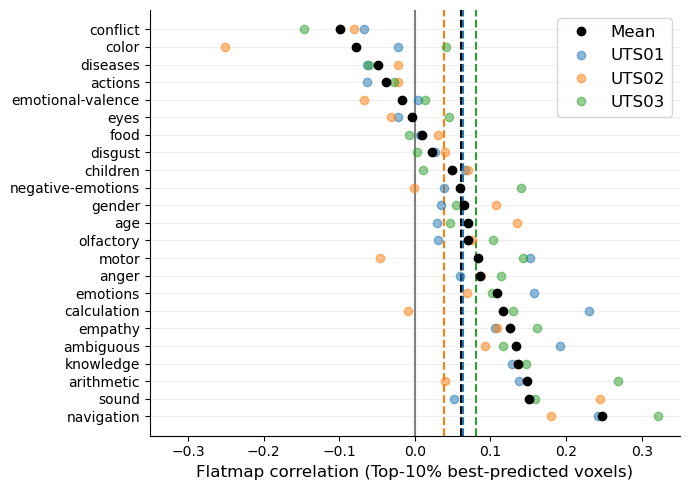

In [3]:
c = corrs_df
xlab = f'Flatmap correlation (Top-{int(100*frac_voxels_to_keep)}% best-predicted voxels)'
plt.figure(figsize=(7, 5))
colors = {
    'UTS01': 'C0',
    'UTS02': 'C1',
    'UTS03': 'C2',
    'mean': 'black'
}

d_mean = pd.DataFrame(c.groupby('questions')[
    f'corrs_{frac_voxels_to_keep}'].mean()).reset_index()
d_mean['subject'] = 'mean'
c = pd.concat([c, d_mean])
c = c.set_index('questions')

for subject in ['mean', 'UTS01', 'UTS02', 'UTS03']:
    corrs_df_subject = c[c['subject'] == subject]
    if subject == 'mean':
        idx_sort = corrs_df_subject[f'corrs_{frac_voxels_to_keep}'].sort_values(
            ascending=False).index
    corrs_df_subject = corrs_df_subject.loc[idx_sort]

    # plot corrs
    if subject == 'mean':
        plt.errorbar(
            corrs_df_subject[f'corrs_{frac_voxels_to_keep}'],
            range(len(corrs_df_subject)),
            color='black',
            fmt='o',
            zorder=1000,
            label=subject.capitalize(),
        )
    else:
        plt.errorbar(
            corrs_df_subject[f'corrs_{frac_voxels_to_keep}'],
            range(len(corrs_df_subject)),
            # xerr=np.sqrt(
            # r_df[f'corrs_{frac_voxels_to_keep}'] * (1-r_df[f'corrs_{frac_voxels_to_keep}'])
            # / r_df['num_test']),
            alpha=0.5,
            label=subject.upper(),
            fmt='o')
    plt.axvline(corrs_df_subject[f'corrs_{frac_voxels_to_keep}'].mean(),
                linestyle='--', color=colors[subject], zorder=-1000)

    print('mean corr', corrs_df_subject[f'corrs_{frac_voxels_to_keep}'].mean())

# add horizontal bars
plt.yticks(range(len(corrs_df_subject)), [term_dict_rev[k] for k in idx_sort])
plt.xlabel(xlab, fontsize='large')
plt.grid(axis='y', alpha=0.2)
plt.axvline(0, color='gray')

abs_lim = max(np.abs(plt.xlim()))
plt.xlim(-abs_lim, abs_lim)

# annotate with baseline and text label
plt.legend(fontsize='large')
plt.tight_layout()
plt.savefig(join(repo_dir, 'qa_results',
            'neurosynth', 'corrs_' + setting + '.png'), dpi=300)

### Compute pvals

In [4]:
subject = 'UTS03'
corrs_df_subject = corrs_df[corrs_df['subject']
                            == subject].set_index('questions')

# corrs_df = pd.DataFrame(corrs_df_dict)
flatmaps_qa_list_subject = [flatmaps_qa_dict[q]
                            for q in corrs_df_subject.index]
for frac_voxels_to_keep in tqdm(frac_voxels_to_keep_list):
    eng1000_dir = join(PROCESSED_DIR, subject.replace(
        'UT', ''), 'eng1000_weights.pkl')
    pvals = viz.compute_pvals(flatmaps_qa_list_subject, frac_voxels_to_keep,
                              corrs_df_subject[f'corrs_{frac_voxels_to_keep}'].values, eng1000_dir=eng1000_dir)

    # get what fraction of 'corrs_perm_eng1000' column is greater than f'corrs_{frac_voxels_to_keep}'
    corrs_df_subject[f'pval_{frac_voxels_to_keep}'] = pvals

# format scientific notation
corrs_df_subject.sort_values(
    by=f'pval_{frac_voxels_to_keep}').style.background_gradient().format(precision=3)

100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


,corrs_0.1,subject,pval_0.1
questions,,,
Does the input mention anything related to navigation?,0.322,UTS03,0.236
Does the input mention anything related to motor movements?,0.143,UTS03,0.358
Does the input mention anything related to arithmetic?,0.268,UTS03,0.384
Does the input mention or describe a smell?,0.104,UTS03,0.397
Does the input mention anything related to calculation?,0.129,UTS03,0.416
Does the input mention or describe highly positive emotional valence?,0.102,UTS03,0.421
Does the input mention or describe highly negative emotional valence?,0.140,UTS03,0.422
Does the input mention or describe a sound?,0.158,UTS03,0.424
Does the input mention anything related to empathy?,0.162,UTS03,0.436


### Re-do analysis in MNI space

In [5]:
from cortex import mni
import os
os.environ["FSLDIR"] = "/home/chansingh/fsl"

In [6]:
def convert_to_mni_space(flatmap_arr, subject='UTS01'):
    flatmap_vol = cortex.Volume(
        data=flatmap_arr.flatten(), subject=subject, xfmname=f'{subject}_auto')
    flatmap_to_mni_cached = cortex.db.get_mnixfm(subject, f'{subject}_auto')
    mni_vol = mni.transform_to_mni(flatmap_vol, flatmap_to_mni_cached)
    mni_arr = mni_vol.get_fdata()  # the actual array, shape=(182,218,182)
    return mni_arr


qs = corrs_df_subject.index
flatmaps_qa_dict_list_subjects = {subject: [flatmaps_qa_dicts_by_subject[subject][q] for q in qs]
                                  for subject in ['UTS01', 'UTS02', 'UTS03']}
flatmaps_gt_dict_list_subject = {subject: get_neurosynth_flatmaps(subject)
                                 for subject in ['UTS01', 'UTS02', 'UTS03']}

In [7]:
flatmaps_qa_dict_list_subjects_mni = {subject: [convert_to_mni_space(flatmaps_qa_dict_list_subjects[subject][i], subject=subject)
                                                for i in tqdm(range(len(qs)))]
                                      for subject in ['UTS01', 'UTS02', 'UTS03']}

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [04:38<00:00, 12.10s/it]


In [15]:
flatmaps_gt_dict_list_subject_mni = {subject: [convert_to_mni_space(flatmaps_gt_dict_list_subject[subject][qs[i]], subject=subject)
                                               for i in tqdm(range(len(qs)))]
                                     for subject in ['UTS01', 'UTS02', 'UTS03']}

100%|██████████| 23/23 [01:06<00:00,  2.88s/it]


In [25]:
corrs_avg_df = defaultdict(list)
for question_idx in tqdm(range(len(qs))):

    subjects = ['UTS01', 'UTS02', 'UTS03']
    flatmap_avg_mni = None
    for subject in subjects:
        # flatmap_qa_arr = flatmaps_qa_dict_list_subjects[subject][question_idx]
        # flatmap_qa_mni = convert_to_mni_space(flatmap_qa_arr, subject=subject)
        flatmap_qa_mni = flatmaps_qa_dict_list_subjects_mni[subject][question_idx]
        if flatmap_avg_mni is None:
            flatmap_avg_mni = flatmap_qa_mni
        else:
            flatmap_avg_mni += flatmap_qa_mni

        # flatmap_gt_arr = flatmaps_gt_dict_list_subject[subject][qs[question_idx]]
        # flatmap_gt_mni = convert_to_mni_space(flatmap_gt_arr, subject=subject)
        flatmap_gt_mni = flatmaps_gt_dict_list_subject_mni[subject][question_idx]
        # print('corr', np.corrcoef(flatmap_qa_arr.flatten(),
        #   flatmap_gt_arr.flatten())[0, 1])
        corrs_avg_df[f'corr_{subject}'].append(np.corrcoef(flatmap_qa_mni.flatten(),
                                                           flatmap_gt_mni.flatten())[0, 1])

    flatmap_avg_mni /= len(subjects)
    corrs_avg_df['questions'].append(qs[question_idx])
    corrs_avg_df['corr_avg'].append(np.corrcoef(flatmap_avg_mni.flatten(),
                                                flatmap_gt_mni.flatten())[0, 1])
    # corrs_avg_df['flatmap_qa'].append(flatmap_avg_mni)

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


In [27]:
df = pd.DataFrame(corrs_avg_df).sort_values(
    'corr_avg', ascending=False).set_index('questions')
# add avg row to bottom
df.loc['avg'] = df.mean()

In [32]:
df.style.background_gradient(axis=None).format(precision=3)

,corr_UTS01,corr_UTS02,corr_UTS03,corr_avg
questions,,,,
Does the input mention anything related to navigation?,0.306,0.231,0.282,0.305
Does the input mention anything related to arithmetic?,0.231,0.189,0.211,0.233
Does the input mention or describe a smell?,0.122,0.072,0.142,0.138
Does the input mention anything related to calculation?,0.144,0.116,0.107,0.128
Does the input mention or describe a sound?,0.101,0.157,0.059,0.116
Does the input mention or describe highly positive emotional valence?,0.116,0.106,0.058,0.107
Does the input contain a sense of ambiguity?,0.098,0.076,0.101,0.103
Does the input mention anything related to gender?,0.107,0.074,0.075,0.097
Does the input mention anything related to knowledge?,0.108,0.068,0.061,0.082


### Look at merged flatmaps

In [ ]:
corrs_df = pd.read_pickle(join(repo_dir, 'qa_results',
                               'neurosynth', setting + '_corrs_df.pkl'))

In [ ]:
setting = 'shapley_neurosynth'
for subject in ['UTS01', 'UTS02', 'UTS03']:
    img_dir1 = join(repo_dir, 'qa_results', 'neurosynth',
                    subject, 'neurosynth')
    img_dir2 = join(repo_dir, 'qa_results', 'neurosynth',
                    subject, setting)

    # read images and combine them with their filenames on a single plot
    # fnames = os.listdir(img_dir1)
    # fnames = [f for f in fnames if f.endswith('.png')]
    # only keep the ones that are in both directories
    # fnames = [f for f in fnames if f in os.listdir(img_dir2)]

    corrs = corrs_df[corrs_df['subject'] == subject]
    # corrs = corrs.sort_values(f'corrs_{frac_voxels_to_keep}', ascending=False)
    fnames = [v + '.png' for v in corrs['questions'].values]

    n = len(fnames)
    C = 4
    R = int(np.ceil(n / C))

    fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
    axs = axs.flatten()
    for i in range(len(axs)):
        axs[i].axis('off')
    for i, fname in enumerate(fnames):
        img1 = plt.imread(join(img_dir1, fname))
        img2 = plt.imread(join(img_dir2, fname))
        axs[i].imshow(np.concatenate([img1, img2], axis=1))
        axs[i].set_title(
            f'{term_dict_rev[fname[:-4]]} ({corrs["corrs"].values[i]:0.3f})', fontsize=8)

    # add text in bottom right of figure
    fig.text(0.99, 0.01, f'{subject}\nNeurosynth on left, QA on right',
             ha='right', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(join(repo_dir, 'qa_results', 'neurosynth',
                subject, f'flatmaps_{setting}_{subject}.png'), dpi=300)
    plt.close()